<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import Pool, CatBoostRegressor
import lightgbm as lgb
from numpy.random import RandomState
from sklearn.model_selection import TimeSeriesSplit
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('/datasets/taxi.csv')
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [6]:
data.set_index('datetime', inplace=True)

In [7]:
data = data.sort_index(axis=0)
data.index.is_monotonic

True

В данных нет пропусков. Данные расположены последовательно во времени.

In [8]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Данные идут с периодичностью 10 минут.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [10]:
data['num_orders'].unique()

array([  9,  14,  28,  20,  32,  21,   7,   5,  17,  12,  19,  25,  22,
         8,   6,   4,  10,  13,   2,   3,   0,   1,  11,  15,  16,  23,
        18,  33,  24,  26,  30,  38,  34,  42,  31,  27,  36,  29,  35,
        56,  37,  40,  39,  45,  49,  58,  68,  43,  53,  44,  41,  52,
        46,  57,  47,  64,  61,  50,  48,  55,  62,  54,  71,  78, 119,
        99,  51,  60,  87,  90,  94,  82,  80,  91,  76,  66,  65,  98,
        81,  95,  67])

В данных нет выбросов.

Выполним ресемплирование по одному часу. Чтобы получилось количество заказов в час применим функцию суммы.

In [11]:
data = data.resample('1H').sum()

<b> Вывод: в данных нет ошибок или пропусков, и они идут последовательно.

## Анализ

Данные представленны в период с 01-03-18 по 31-08-18, то есть за полгода.

<AxesSubplot:xlabel='datetime'>

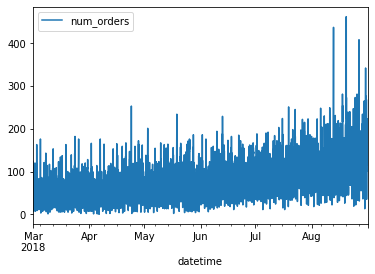

In [12]:
data.plot()

In [13]:
decomposed = seasonal_decompose(data['num_orders'])

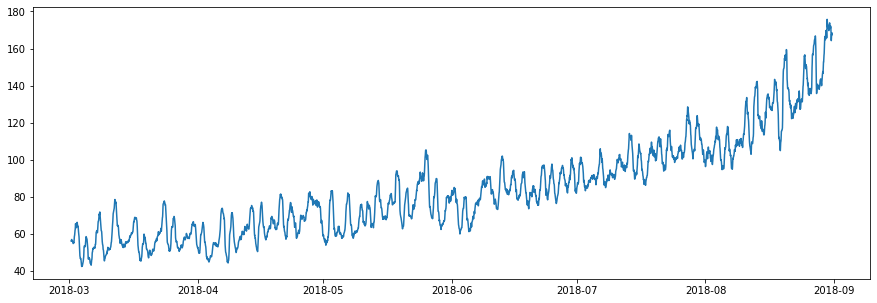

In [14]:
plt.figure(figsize=[15, 5])
plt.plot(decomposed.trend)

По графику тренда можно сказать, что среднее количество заказов растет с марта и до конца августа.

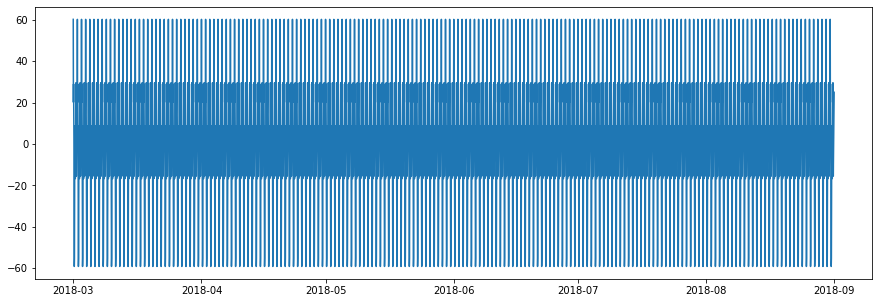

In [15]:
plt.figure(figsize=[15, 5])
plt.plot(decomposed.seasonal)

Сезонности нет. Стандартные колебания с определенной закономерностью.

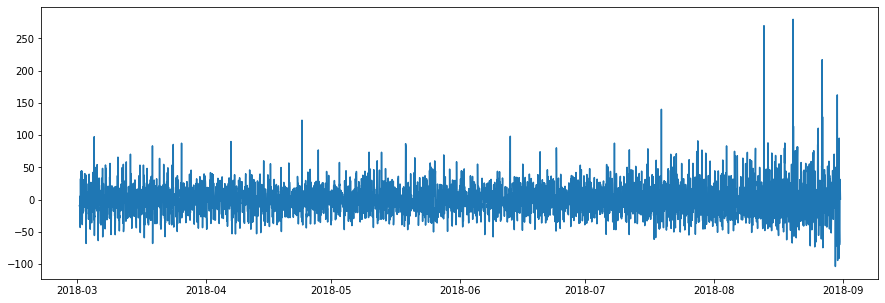

In [16]:
plt.figure(figsize=[15, 5])
plt.plot(decomposed.resid)

<b> Вывод: данный временной ряд не обладает сезонность. Среднее количество заказов растет с первой даты до последней.

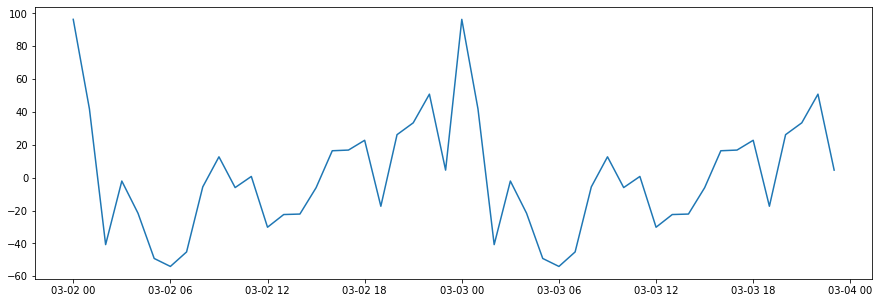

In [33]:
plt.figure(figsize=[15, 5])
plt.plot(seasonal_decompose(data['2018-03-01':'2018-03-03']['num_orders']).seasonal)

## Обучение

Добавим признаки для более точного предсказания.

In [17]:
def add_features(data, max_lag, rolling_mean_size):    
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag+1):
          data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [18]:
data = add_features(data, 24, 24)

Метрика на тесте должна быть ниже 48, поэтому стоит задать параметр max_lag равным 24 при создании новых признаков функцией. В случае заказов такси самая очевидная сезонность - внутри суток, а в сутках 24 часа, это значение и будет оптимальным

In [19]:
data.head()

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Удалим строки с пустыми значениями.

In [20]:
data = data.dropna()

In [21]:
state = RandomState(12345)

In [22]:
train, test = train_test_split(data ,shuffle=False, random_state = state, test_size = 0.1)

In [23]:
print(train.shape[0], test.shape[0])

3952 440


In [24]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [25]:
state = RandomState(12345)

In [26]:
splits = TimeSeriesSplit(n_splits=9)

*RandomForestRegressor*

In [27]:
%%time
model_rf = RandomForestRegressor()
params = dict(max_depth=[10,50], n_estimators=np.arange(10,150,10))
rf = RandomizedSearchCV(model_rf, params, cv=splits, scoring='neg_mean_squared_error', random_state=state)
rf.fit(features_train, target_train)
rmse = (-rf.best_score_) ** 0.5
print(rf.best_params_)
print(rmse)

{'n_estimators': 110, 'max_depth': 50}
24.685494431765978
CPU times: user 2min 44s, sys: 312 ms, total: 2min 45s
Wall time: 2min 45s


*CatBoostRegressor*

In [28]:
%%time
train_pool = Pool(features_train, target_train)
cat = CatBoostRegressor(loss_function="RMSE", verbose=False)
params = {"depth": [5,10]}
grid_search_results = cat.grid_search(params, train_pool, cv=splits, verbose=False, plot=False)


bestTest = 34.5718199
bestIteration = 267


bestTest = 38.47196229
bestIteration = 320

Training on fold [0/9]

bestTest = 20.02044219
bestIteration = 256

Training on fold [1/9]

bestTest = 19.36373578
bestIteration = 800

Training on fold [2/9]

bestTest = 22.13065391
bestIteration = 987

Training on fold [3/9]

bestTest = 22.04467145
bestIteration = 956

Training on fold [4/9]

bestTest = 21.91371924
bestIteration = 992

Training on fold [5/9]

bestTest = 24.04657518
bestIteration = 940

Training on fold [6/9]

bestTest = 23.17636601
bestIteration = 957

Training on fold [7/9]

bestTest = 28.52911063
bestIteration = 992

Training on fold [8/9]

bestTest = 30.43753443
bestIteration = 908

CPU times: user 1min 26s, sys: 1.33 s, total: 1min 27s
Wall time: 1min 31s


**Вывод: обучены 2 модели - RandomForest и CatBoost**

## Тестирование

*RandomForestRegressor*

In [29]:
model_rf = RandomForestRegressor(max_depth=50, n_estimators=120)
model_rf.fit(features_train, target_train)
predictions = model_rf.predict(features_test)
rmse = mean_squared_error(target_test, predictions, squared=False)
print('RMSE:', rmse)

RMSE: 42.97369877746343


RMSE=42.97 < 48

CatBoostRegressor

In [30]:
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions, squared=False)
print('RMSE:', rmse)

0:	learn: 36.8869811	total: 9.48ms	remaining: 9.47s
1:	learn: 35.2655869	total: 15.8ms	remaining: 7.87s
2:	learn: 33.8728064	total: 22ms	remaining: 7.3s
3:	learn: 32.6481322	total: 28ms	remaining: 6.96s
4:	learn: 31.5281469	total: 33.9ms	remaining: 6.75s
5:	learn: 30.6422049	total: 39.7ms	remaining: 6.58s
6:	learn: 29.7951465	total: 45.8ms	remaining: 6.5s
7:	learn: 29.0300129	total: 51.6ms	remaining: 6.39s
8:	learn: 28.2738472	total: 57.2ms	remaining: 6.3s
9:	learn: 27.6489335	total: 63.2ms	remaining: 6.26s
10:	learn: 27.1448028	total: 69.1ms	remaining: 6.21s
11:	learn: 26.6724105	total: 74.8ms	remaining: 6.16s
12:	learn: 26.3739046	total: 80.7ms	remaining: 6.13s
13:	learn: 25.9688211	total: 86.4ms	remaining: 6.09s
14:	learn: 25.6275579	total: 92.3ms	remaining: 6.06s
15:	learn: 25.3479873	total: 98.2ms	remaining: 6.04s
16:	learn: 25.0674113	total: 104ms	remaining: 6.01s
17:	learn: 24.8299179	total: 110ms	remaining: 6s
18:	learn: 24.5721573	total: 115ms	remaining: 5.96s
19:	learn: 24.35

RMSE=40.16 < 48

<b> Вывод: самой точной оказалась модель CatBoostRegressor.

Text(0.5, 0, 'Дата и время')

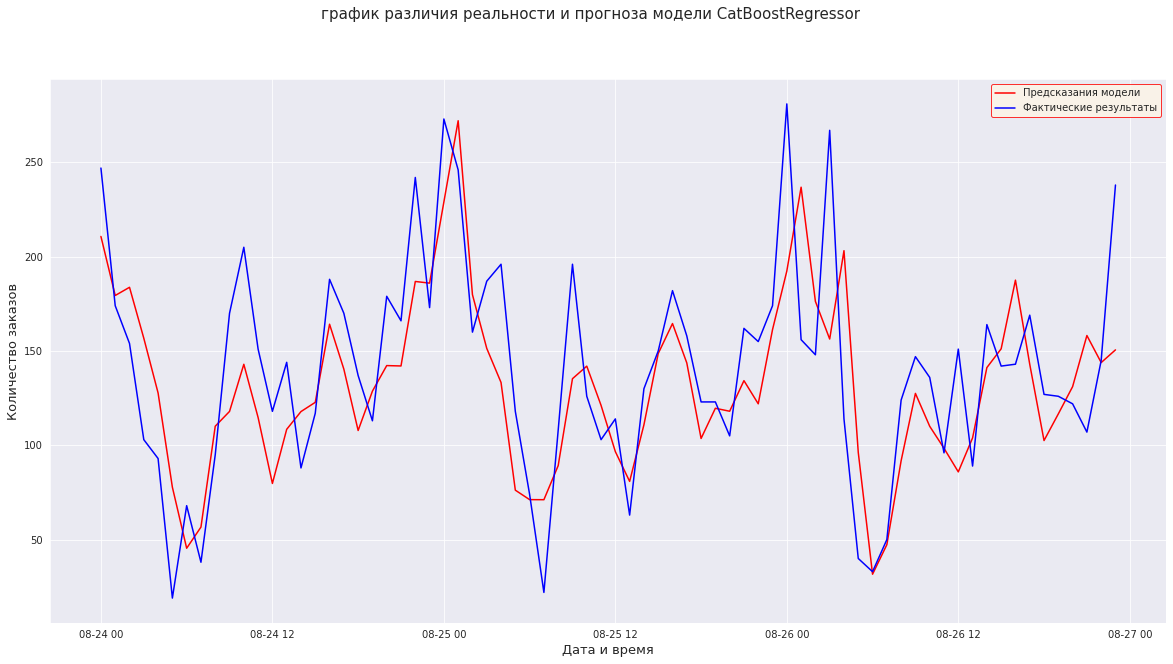

In [49]:
plt.figure(figsize=[20, 10])
plt.suptitle('график различия реальности и прогноза модели CatBoostRegressor', fontsize=15)
plt.grid(True)

chart_for_predict = pd.DataFrame(data=predictions, index=target_test.index)
plt.plot(chart_for_predict['2018-08-24':'2018-08-26'], label='Предсказания модели', color='r')
plt.plot(target_test['2018-08-24':'2018-08-26'], label='Фактические результаты', color='b')
plt.legend(edgecolor = 'r', facecolor = 'oldlace')
plt.ylabel('Количество заказов', fontsize=13)
plt.xlabel('Дата и время', fontsize=13)

## Общий вывод

**В данном проекте мы иследовали исторические данные о количестве заказов такси в разное время, и на их основании предсказывали количество на следующий час. В данных не было выбросов и пропусков, потому сразу перешли к анализу. Анализ показал плавный рост заказов с марта по август. Сезонность не выявлена. Затем были обучены 2 модели для предсказаний. Самой точной оказалось модель CatBoostRegressor. RMSE на тестовой выборке составил 40.16**